<a href="https://colab.research.google.com/github/harnalashok/deeplearning-sequences/blob/main/forecastingTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
import numpy as np
import matplotlib.pyplot as plt

In [91]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# Constants
n_steps = 50
batch_size = 

In [ ]:
time = np.linspace(0,1,50)
time

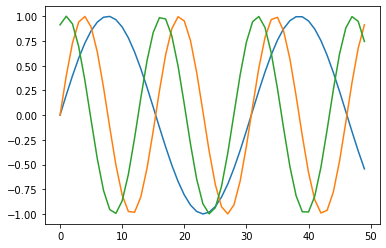

In [95]:
_= plt.plot(np.sin(time*10))
_= plt.plot(np.sin(time*10 * 2))        # Double freq
_= plt.plot(np.sin(time*10 * 2 + 20))   # Double freq, displaced
#_= plt.plot(np.sin(time*10 * 4))       # Four times freq

In [96]:
rng = np.random.default_rng()

In [ ]:
rng.random(size=(4,3,1))

In [ ]:
# Each is a set of 3 numbers of one column each
freq1, freq2, offsets1, offsets2 = rng.random(size=(4,3,1))
print("\n-------\n")
freq1
print("\n-------\n")
freq2
print("\n-------\n")
offsets1
print("\n-------\n")
offsets2

In [ ]:
# Get 50 pts in time
time = np.linspace(0,1,50)
time

In [ ]:
# Get three sets of 50 numbers each   
theta1 = time - offsets1   # time gets subtracted 3 times
                          #  by each one of the offsets, in turn 
theta1  
theta1.shape   # (3, 50)

In [109]:
# We get three time series each with a different frequency
#  For every one of the 3, thetas, 
freq1 = freq1 * 10 + 10
series = 0.5 * np.sin(theta1 * freq1) # We have three time series
series.shape

(3, 50)

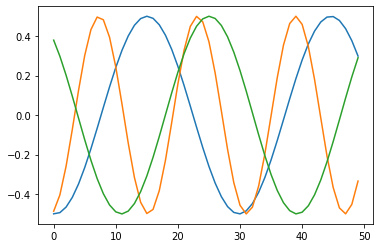

In [110]:
_= plt.plot(series[0])
_= plt.plot(series[1])
_= plt.plot(series[2])

In [111]:
theta2 = time - offsets2
freq2 = freq2 * 20 + 20
series += 0.2 * np.sin(theta2 * freq2) # We have three time series
series.shape

(3, 50)

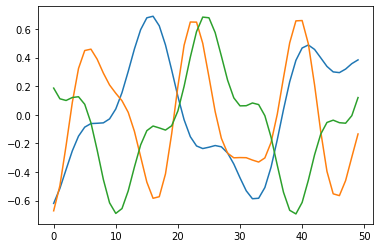

In [112]:
_= plt.plot(series[0])
_= plt.plot(series[1])
_= plt.plot(series[2])

In [114]:
series += 0.1 * ((rng.random(size = (3,50))) - 0.5)

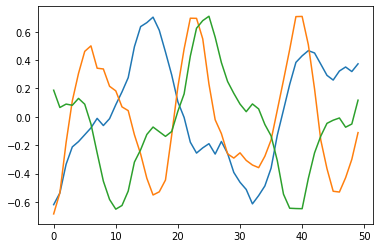

In [115]:
_= plt.plot(series[0])
_= plt.plot(series[1])
_= plt.plot(series[2])

In [ ]:
series = series[...,np.newaxis].astype(np.float32)
series.shape